# Sequence analysis by MobileNet

Apziva project #4: "MonReader"<br>
2023 08 05

__Summary:__
* In notebook "Binary classifiers", Inception was identified as the transfer-learning model with the highest F1 score.
    * However, Inception requires __92__ MB (version 3), which currently exceeds the typical size for mobile applications, a current __threshold__ being around __45 MB__.
    * Thus, for practical reasons, Inception has to be __discarded__.
    * On the other hand, MobileNet performs almost as well as Inception, with an F1 score of 98.6% rather than 99.1%.
* Therefore in this notebook, the sequence of frames is analysed with this second-best combination __MobileNet / cropping / SVM__.
    * PCA n is increase from 20 to 50.
    * C and gamma stay the same: 5 and 0.01.
* This second-best model yields __qualitatively the same result__ as the top-ranked Inception model.

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)
* [General settings](#GeneralSetting)
* [Getting a sequence](#GettingSequence)    
* [Analyzing sequence](#AnalyzingSequence)    
    * [Image pre-processing](#ImagePreprocessing)    
        * [Squaring](#Squaring)
        * [HLF](#HLF)
    * [Re-train best model](#RetrainBestModel)        
    * [Apply best model](#ApplyBestModel)    

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## General settings <a class="anchor" id="GeneralSetting"></a>
[TOC](#TOC)

In [2]:
# constants

# general
cfltRandomSeed = 42 # any number

# files
cstrDownloadRoot =         "../../OutsideRepository/ImagesRaw/"
cstrImagePreparationRoot = "../../OutsideRepository/ImagesProcessed/"

cdintSquareSides =            {"Inception":299,"MobileNet":224}

clstrTransferLearningModels = ["Inception","MobileNet"]
clstrSquaringStrategies     = ["Squeeze","Crop"]

clstrDownloadDatasets =       ["training","testing"]
clstrDownloadClasses  =       ["flip","notflip"]

clstrMLModels =               ["L2","Random Forest","SVM"]

## Getting a sequence <a class="anchor" id="GettingSequence"></a>
[TOC](#TOC)

In [3]:
cstrRootPath = "../../OutsideRepository/ImagesRaw/testing/"

# manual selection of sequence frames
# - n = notflip
# - f = flip
strSequence = ""
strSequence += "n 7 10,n 7 25,"
strSequence += "f 6 6,f 6 8,f 6 12,f 6 21,f 6 22,f 6 24,f 6 25,f 6 30,"
strSequence += "n 8 8,n 8 9,n 8 12,n 8 13,n 8 20,n 8 23,"
strSequence += "f 7 8,f 7 18,f 7 24"

# derive filenames
lstrFilenames = []
lstrImageCodes = strSequence.split(',')
for strImageCode in lstrImageCodes:
    strClassShort,strLeftNumber,strRightNumber = strImageCode.split(' ')
    strFilename = f"{strLeftNumber.zfill(4)}_{strRightNumber.zfill(9)}.jpg"
    strFolder = "flip" if strClassShort == "f" else "notflip"
    strFullFilename = f"{cstrRootPath}{strFolder}/{strFilename}"
    lstrFilenames.append(strFullFilename)

Sequence to be analyzed:


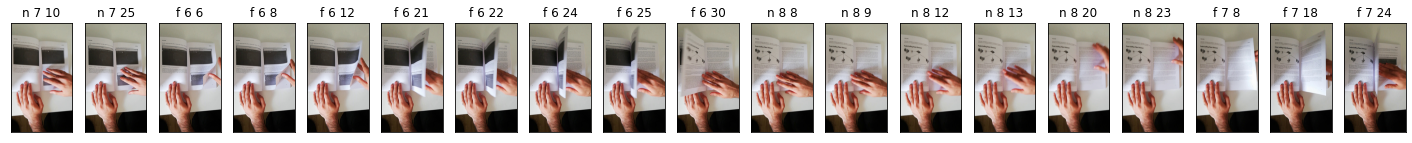

In [4]:
from PIL import Image
import numpy as np

# get images as numpy arrays
limgFrames = []
for strFullFilename in lstrFilenames:
    pilImage = Image.open(strFullFilename)
    a3intImage = np.array(pilImage)
    limgFrames.append(a3intImage)

p("Sequence to be analyzed:")
u.PhotoGallery(limgFrames,lstrImageCodes,intColumns=len(limgFrames),fltWidth=25,fltHeight=3)

## Analyzing sequence <a class="anchor" id="AnalyzingSequence"></a>
[TOC](#TOC)

### Image pre-processing <a class="anchor" id="ImagePreprocessing"></a>
[TOC](#TOC)

#### Squaring <a class="anchor" id="Squaring"></a>
[TOC](#TOC)

In [11]:
from PIL import Image
def CroppedToSquare(a3intInput, intSquareSide):
    '''
    Crops an image to a square of a given size by keeping the central part.
    The aspect ratio is preserved.
    When       Who What
    2023 08. 05 dh  Created
    '''  
    # open image
    pilImage = Image.fromarray(a3intInput)

    # original image size
    intWidth, intHeight = pilImage.size

    # dimensions for cropping and resizing
    intSmallerDimension = min(intWidth, intHeight)
    intLeft = (intWidth - intSmallerDimension) // 2
    intTop = (intHeight - intSmallerDimension) // 2
    intRight = intLeft + intSmallerDimension
    intBottom = intTop + intSmallerDimension

    # crop the image to a square
    pilCroppedImage = pilImage.crop((intLeft, intTop, intRight, intBottom))

    # resize to size required by model
    # - fast: Image.NEAREST
    # - good: Image.ANTIALIAS
    pilResizedImage = pilCroppedImage.resize((intSquareSide, intSquareSide), resample=Image.NEAREST)

    # finalize
    return np.array(pilResizedImage)

#### HLF <a class="anchor" id="HLF"></a>
[TOC](#TOC)

In [12]:
import tensorflow as tf
import tensorflow_hub as hub

gcintChannels = 3
def SequentialModel (strModelName):
    '''
    Loads a transfer learning model.
    Current models available: Inception and MobileNet.
    2022 02 22 dh Created
    '''
    # source URL elements
    # Python 3 (for Python 2 see ADS-ML course project 4)
    cstrUrlPart1 = "https://tfhub.dev/google/imagenet/"
    cstrUrlPart3 = "/feature_vector/5"
    
    # define model parameters
    strModelNameLower = strModelName.lower()
    if strModelNameLower == "inception":
        intSquareSide = 299
        strUrlPart2 = "inception_v3"
    elif strModelNameLower == "mobilenet":
        intSquareSide = 224
        strUrlPart2 = "mobilenet_v2_100_224"
    else:
        p(f"WARNING: The model {strModelName} does not exist. Possible models: Inception and Mobilenet.")
        return
    
    # try to load the model
    strModelUrl = cstrUrlPart1 + strUrlPart2 + cstrUrlPart3
    try:
        objSequentialModel = tf.keras.Sequential([hub.KerasLayer(strModelUrl, trainable=False)])  # can be True, see below.     
    except:
        p("The sequential model cannot be loaded.")
        p(r"Maybe the folder 'C:\Users\domin\AppData\Local\Temp\tfhub_modules' has to be deleted.")
        p(r"At least this was the case in ADS-ML course project 4, under certain conditions.")  
        return
    
    # build model
    lintBatchInputShape = [None, intSquareSide, intSquareSide, gcintChannels]
    objSequentialModel.build(lintBatchInputShape)
    p(f"The sequential model '{strModelName}' has been loaded successfully.")
    return objSequentialModel

### Re-train best model <a class="anchor" id="RetrainBestModel"></a>
[TOC](#TOC)

In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

def TrainedSVM(X_train, y_train):
    '''
    Returns a trained SVM, with pre-processing and hyperparameters from last notebook.
    
    When       Who What
    2023 08 04 dh  Created
    '''  
    
    # define according to notebook "Binary classifiers"
    objPipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50)),
        ('svm', SVC(probability=True, C=5, gamma=0.01))
    ])
    
    # train SVM
    u.StopWatch()
    objPipeline.fit(X_train, y_train)
    
    # finalize
    return objPipeline,u.StopWatch("seconds",blnAsFloat=True)

# get the 4 datasets
strRoot = "../data/processed/MobileNet/Crop/"
for strArray in ["X_train", "y_train", "X_test", "y_test"]:
    exec(f"{strArray} = u.FromDisk(f'{strRoot}/{strArray}.p',strType='')")

# train SVM
objSVM,fltSeconds = TrainedSVM(X_train, y_train)

# compare with result from previous notebook
y_pred = objSVM.predict(X_test)
fltF1 = f1_score(y_test, y_pred)
p("The best model has been re-built.".upper())
p(f"- F1 score on test data: {round(100*fltF1,1)}%")
p(f"- time used:             {round(fltSeconds,2)} s")

THE BEST MODEL HAS BEEN RE-BUILT.
- F1 score on test data: 98.6%
- time used:             2.64 s


__Remark:__
* Setting `probability=True` roughly doubles the computational time.

In [30]:
def SingleRecordPrediction(objModel, X_single):
    '''
    Returns a single prediction.
    
    When       Who What
    2023 08 04 dh  Created
    '''      
    # predict
    y_pred = objModel.predict(X_single)
    y_prob = objModel.predict_proba(X_single)
    
    # finalize
    return y_pred[0], y_prob[0][1]

### Apply best model <a class="anchor" id="ApplyBestModel"></a>
[TOC](#TOC)

In [31]:
cstrTLModel = "MobileNet"
intSquareSide = cdintSquareSides[cstrTLModel]
objSequentialModel = SequentialModel(cstrTLModel)

The sequential model 'MobileNet' has been loaded successfully.


ANALYZING THE SEQUENCE:


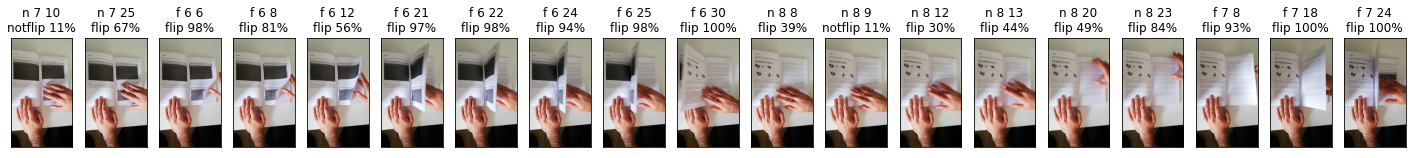

FLIP PROBABILITIES:


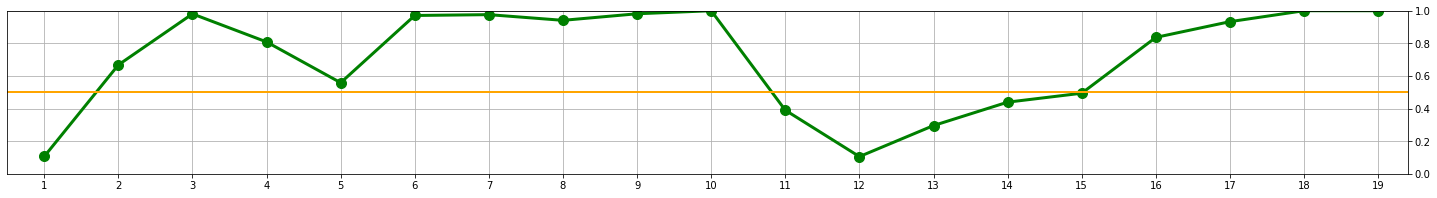

In [32]:
import matplotlib.pyplot as plt

lintPredictions = []
lfltFlipProbabilities = []
for imgFrame in limgFrames[:]:
    
    # init
    lafltAllHighLevelFeatures = []
    
    # squaring
    a3intPixels = CroppedToSquare(imgFrame,intSquareSide)
    
    # extracting HLF
    a4intPixels = np.expand_dims(a3intPixels, axis=0) 
    X_single = objSequentialModel.predict(a4intPixels)
    
    # predict, with probability
    intPrediction,fltFlipProbability = SingleRecordPrediction(objSVM, X_single)
    lintPredictions.append(intPrediction)
    lfltFlipProbabilities.append(fltFlipProbability)

# draw frames, not with prediction and probability in title    
lstrCaptionsWithPrediction = [
    f"{strCode}\n{'flip' if intPrediction == 1 else 'notflip'} {round(100*fltFlipProbability)}%"
    for strCode, intPrediction, fltFlipProbability in zip(lstrImageCodes, lintPredictions, lfltFlipProbabilities)
]
    
p("Analyzing the sequence:".upper())
u.PhotoGallery(limgFrames,lstrCaptionsWithPrediction,intColumns=len(limgFrames),fltWidth=25,fltHeight=3)    

# init plot
p("Flip probabilities:".upper())
fltWidth=25.1
fltHeight=3
plt.figure(figsize=(fltWidth, fltHeight))

# scatterplot
intValueCount = len(lfltFlipProbabilities)
rngXValues = range(1,intValueCount+1)
plt.plot(rngXValues, lfltFlipProbabilities, 'o', color='green',markersize=10)
plt.plot(rngXValues, lfltFlipProbabilities, color='green', linewidth=3)

# finalize
plt.axhline(y=0.5, color='orange', linewidth=2)
plt.xlim(0.5,intValueCount+0.4)
plt.ylim(0, 1)
plt.tick_params(axis='y', which='both', right=True, left=False, labelleft=False, labelright=True)
plt.xticks(range(1, intValueCount+1))
plt.grid(True)
plt.show()

__Comments:__
* Qualitatively, the result is almost the same as with Inception:
    * The SVM __detects__ flipping and non-flipping __sub-sequences__.
    * Here not only the outcome (flip/notflip) is displayed, but also the probability for `flip`.
    * Frame 2 is mis-classified:
        * However, this frame shows that the SVM even detects the __transition__ from `notflip` to `flip`.
        * The prediction for this frame is made on a probability __close to 50%__, i.e. to pure chance.
* __Differences__ to the Inception analysis:
    * Frame 5: MobileNet is __less confident__ to qualify the frame as `flip`, but still outputs `flip`.
    * Frame 15: Again, the decision is correct, but MobilneNet has a __probability of only 49%/51%__.
    * Frame 16: The frame is misclassified by MobileNet, but actually the __human classifier__ could be __wrong__ too in this case.
* Outcome (0/1) and probabilities:
    * The outcomes 0/1 are __not strictly correlated__ to a decision boundary of 0.5.
    * Instead, the boundary seems to be somewhere around 25%.
    * Internet sources claim that 
        * "SVM is primarily concerned with correctly classifying points, and the __probability estimates are secondary__."
        * "The probability estimates from SVM are __not always well-calibrated__."
    * Regardless of whether outcomes or probabilities are considered, the model is __good enough__ to separate __flipping sub-sequences__ from __non-flipping sub-sequences__.